In [77]:
import pandas as pd

df = pd.read_csv('Housing.csv')

print(df.head())
print(df.dtypes) 

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
price                int64
area                 int64
bedrooms             int64
bathrooms         

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

print(df.columns)
df.columns = df.columns.str.strip()

#df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)


Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('furnishingstatus', axis=1)
y = df['furnishingstatus']

# Assuming df is your DataFrame
# Convert binary columns
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Define X and y
X = df.drop('furnishingstatus', axis=1)
y = df['furnishingstatus']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, C=1.0)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [80]:
svc = SVC()
knn = KNeighborsClassifier()

linear_svc = LinearSVC(dual=False, max_iter=1000)
linear_svc.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [81]:
import warnings
warnings.filterwarnings('ignore')

log_reg_predictions = log_reg.predict(X_test)
linear_svc_predictions = linear_svc.predict(X_test)
svc_predictions = svc.predict(X_test)
knn_predictions = knn.predict(X_test)

if not X_train.columns.equals(X_test.columns):
    print("Feature names in X_train and X_test do not match.")
    print("Features in X_train but not in X_test:", set(X_train.columns) - set(X_test.columns))
    print("Features in X_test but not in X_train:", set(X_test.columns) - set(X_train.columns))
else:
    print("Feature names match. Safe to proceed with predictions.")

Feature names match. Safe to proceed with predictions.


In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_predictions))
print("Linear SVC Accuracy:", accuracy_score(y_test, linear_svc_predictions))
print("SVC Accuracy:", accuracy_score(y_test, svc_predictions))
print("KNN Accuracy:", accuracy_score(y_test, knn_predictions))

print("Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, log_reg_predictions))

Logistic Regression Accuracy: 0.26605504587155965
Linear SVC Accuracy: 0.3669724770642202
SVC Accuracy: 0.4954128440366973
KNN Accuracy: 0.5137614678899083
Confusion Matrix (Logistic Regression):
 [[29  0  0]
 [39  0  0]
 [41  0  0]]


In [83]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize
import scipy.stats

#df[['furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']] = df[['furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']].astype(np.float32)

#y = df['price'].to_numpy(dtype='float32')
#X = df.drop(columns='price').to_numpy()

print("Non-numeric data in X:", df.drop(columns='price').select_dtypes(exclude=[np.number]).columns.tolist())

print("NaNs in X:", np.isnan(X).any())
print("Infs in X:", np.isinf(X).any())

# Standardization with epsilon to avoid division by zero
epsilon = 1e-7
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + epsilon)

n, p = X.shape
X = np.hstack((np.ones((n, 1)), X))

Non-numeric data in X: ['furnishingstatus']
NaNs in X: price              False
area               False
bedrooms           False
bathrooms          False
stories            False
mainroad           False
guestroom          False
basement           False
hotwaterheating    False
airconditioning    False
parking            False
prefarea           False
dtype: bool
Infs in X: price              False
area               False
bedrooms           False
bathrooms          False
stories            False
mainroad           False
guestroom          False
basement           False
hotwaterheating    False
airconditioning    False
parking            False
prefarea           False
dtype: bool


In [84]:
def ll(beta):
    preds = X.dot(beta)
    return -np.sum(np.power(y - preds, 2)) / (2 * sigma**2)

In [85]:
sigma = 1
def lprior(beta):
    return np.sum(sp.stats.norm.logpdf(beta, loc=0, scale=1))
def lpost(beta):
    return ll(beta) + lprior(beta)

In [86]:
def mhKernel(lpost, rprop, dprop=lambda new, old: 1.):
    def kernel(x, ll):
        prop = rprop(x)
        lp = lpost(prop)
        a = lp - ll + dprop(x, prop) - dprop(prop, x)
        if (np.log(np.random.rand()) < a):
            x = prop
            ll = lp
        return x, ll
    return kernel

def mcmc(init, kernel, thin=10, iters=10000, verb=True):
    p = len(init)
    ll = -np.inf
    mat = np.zeros((iters, p))
    x = init
    if (verb):
        print(str(iters) + " iterations")
    for i in range(iters):
        if (verb):
            print(str(i), end=" ", flush=True)
        for j in range(thin):
            x, ll = kernel(x, ll)
        mat[i,:] = x
    if (verb):
        print("\nDone.", flush=True)
    return mat

def rprop(beta):
    return beta + 0.02 * np.random.randn(p+1)  # p+1 due to intercept

# Initial guess
init = np.random.randn(p+1) * 0.1

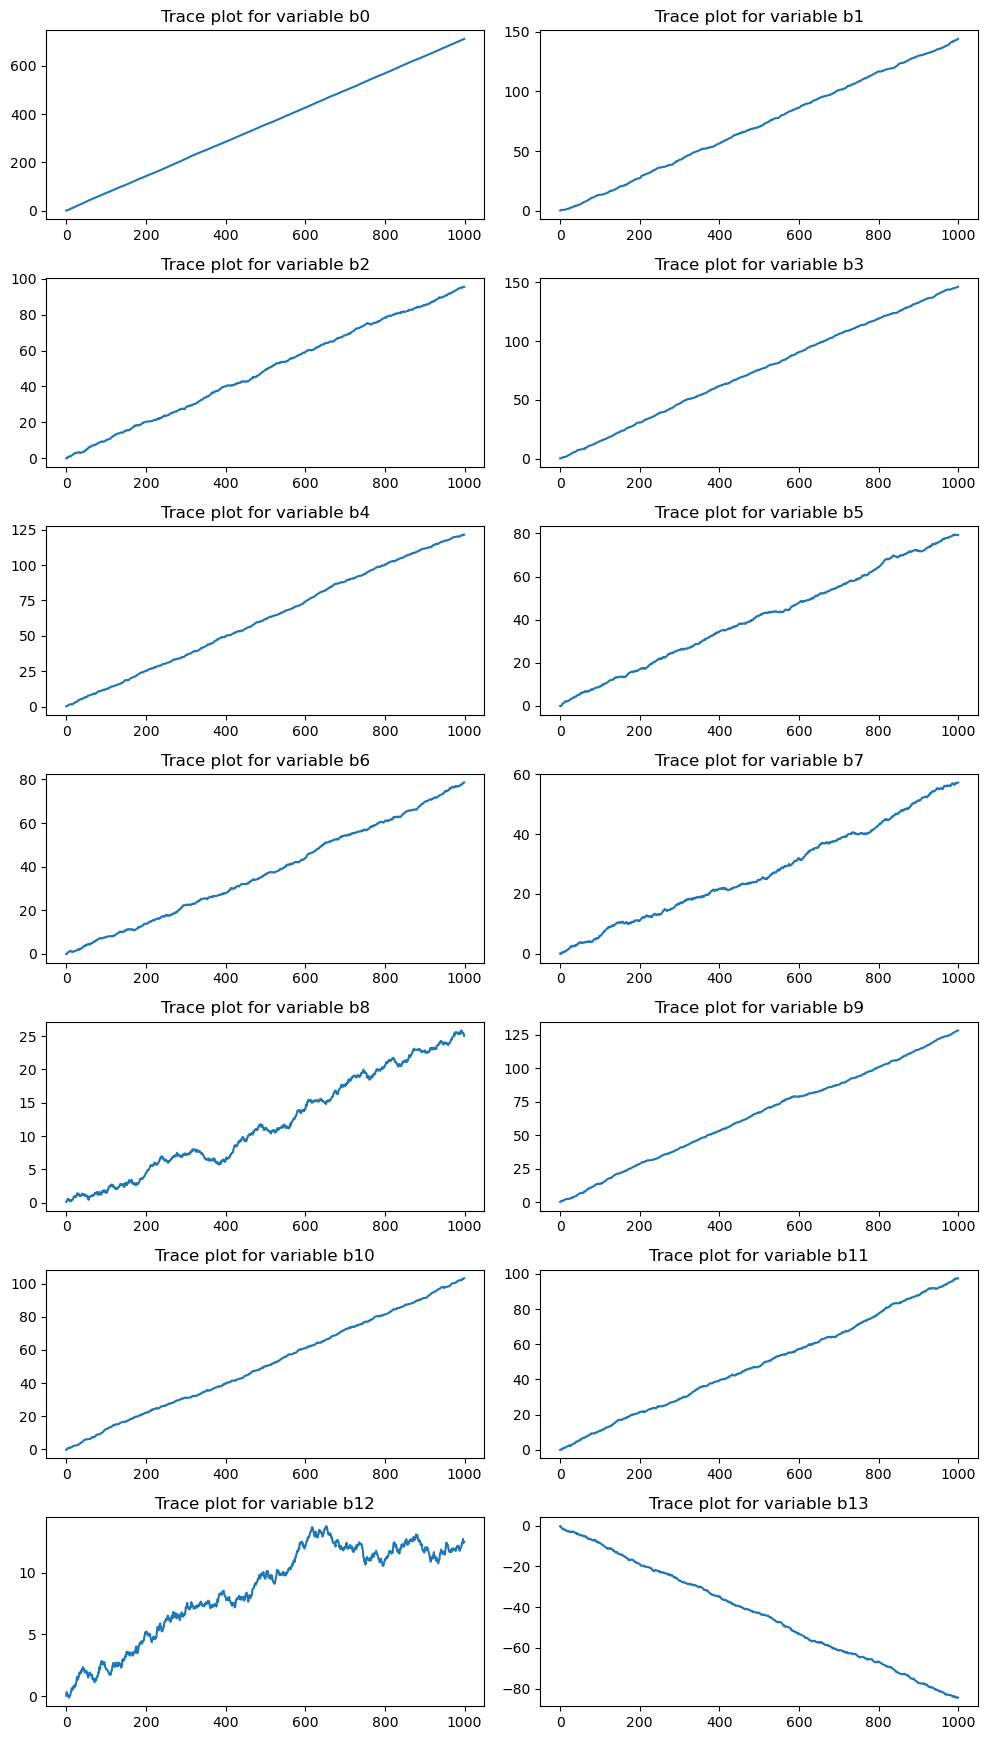

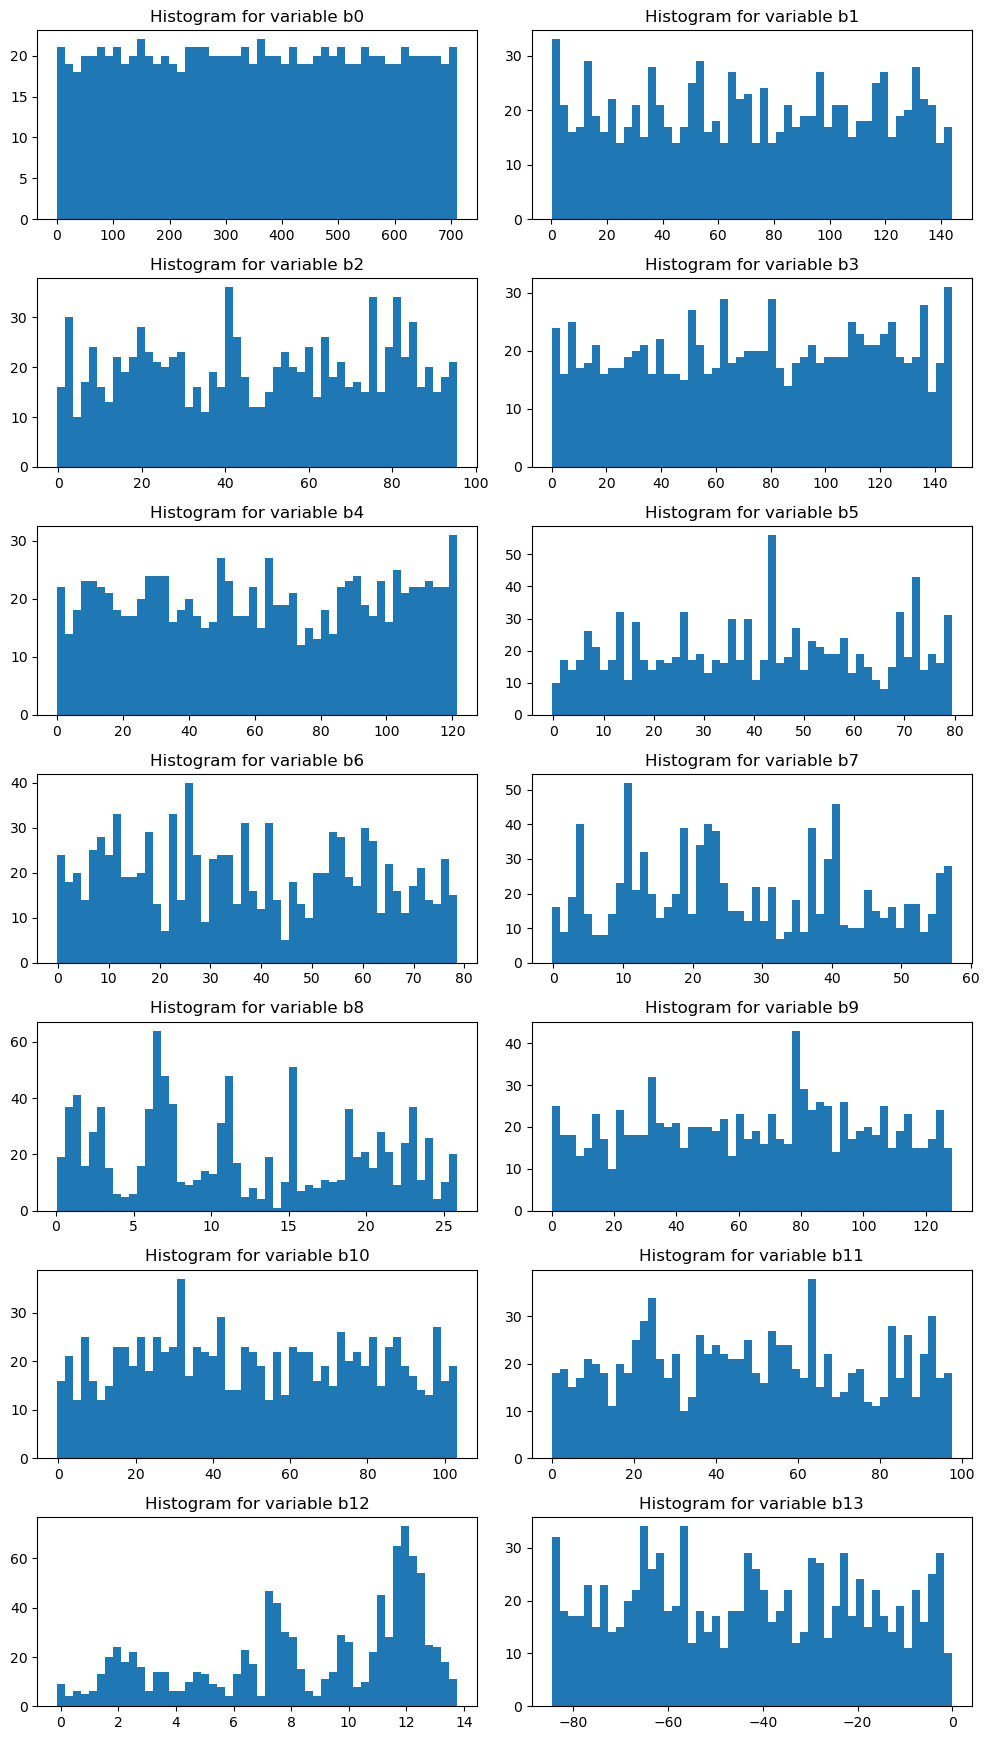

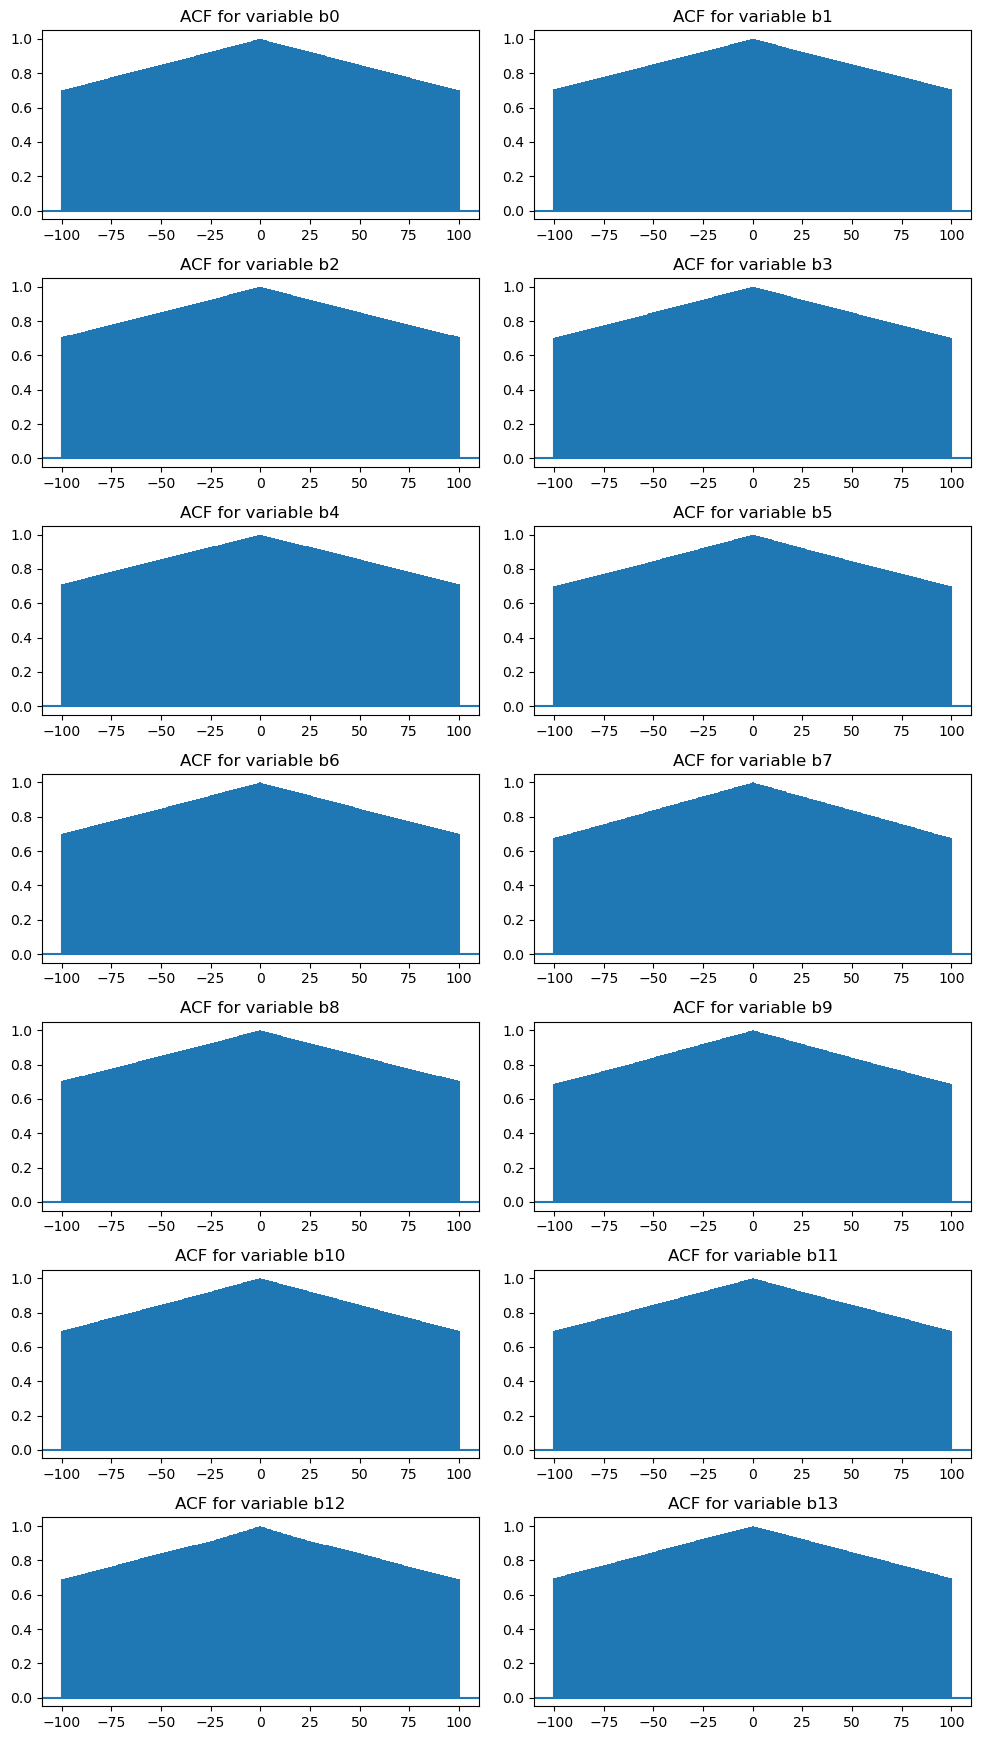

In [87]:
column_names = ["price", "area", "bedrooms", "bathrooms", "stories", "mainroad", "guestroom", "basement", "hotwaterheating", 
                "airconditioning", "parking", "prefarea", "b12", "furnishingstatus"]

odf = pd.DataFrame(out, columns=column_names)
odf.to_parquet("fit-numpy.parquet")

import matplotlib.pyplot as plt

num_params = len(column_names)
num_rows = (num_params + 1) // 2

figure, axis = plt.subplots(num_rows, 2, figsize=(10, num_rows * 2.5))
for i in range(num_params):
    axis[i // 2, i % 2].plot(range(out.shape[0]), out[:,i])
    axis[i // 2, i % 2].set_title(f'Trace plot for variable b{i}')
plt.tight_layout()
plt.savefig("np-trace.png")
plt.show()

figure, axis = plt.subplots(num_rows, 2, figsize=(10, num_rows * 2.5))
for i in range(num_params):
    axis[i // 2, i % 2].hist(out[:,i], 50)
    axis[i // 2, i % 2].set_title(f'Histogram for variable b{i}')
plt.tight_layout()
plt.savefig("np-hist.png")
plt.show()

figure, axis = plt.subplots(num_rows, 2, figsize=(10, num_rows * 2.5))
for i in range(num_params):
    axis[i // 2, i % 2].acorr(out[:,i] - np.mean(out[:,i]), maxlags=100)
    axis[i // 2, i % 2].set_title(f'ACF for variable b{i}')
plt.tight_layout()
plt.savefig("np-acf.png")
plt.show()

In [88]:
log_reg = LogisticRegression(max_iter=1000, C=1.0)
svc = SVC()
knn = KNeighborsClassifier()
linear_svc = LinearSVC(dual=False, max_iter=1000)

In [89]:
log_reg.fit(X_train_scaled, y_train)
svc.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)
linear_svc.fit(X_train_scaled, y_train)

LinearSVC(dual=False)

In [90]:
log_reg.fit(X_train_scaled, y_train)
svc.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)
linear_svc.fit(X_train_scaled, y_train)

LinearSVC(dual=False)

In [91]:
log_reg_predictions = log_reg.predict(X_test_scaled)
linear_svc_predictions = linear_svc.predict(X_test_scaled)
svc_predictions = svc.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_scaled)

In [92]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_reduced = df[['basement', 'price']]

X_reduced_scaled = scaler.fit_transform(X_reduced)
y_encoded = label_encoder.fit_transform(y_train_red)

X_train_red, X_test_red, y_encoded, y_test_red = train_test_split(X_reduced_scaled, y, test_size=0.2, random_state=42)

log_reg.fit(X_train_red, y_encoded)
svc.fit(X_train_red, y_encoded)
knn.fit(X_train_red, y_encoded)
linear_svc.fit(X_train_red, y_encoded)

LinearSVC(dual=False)

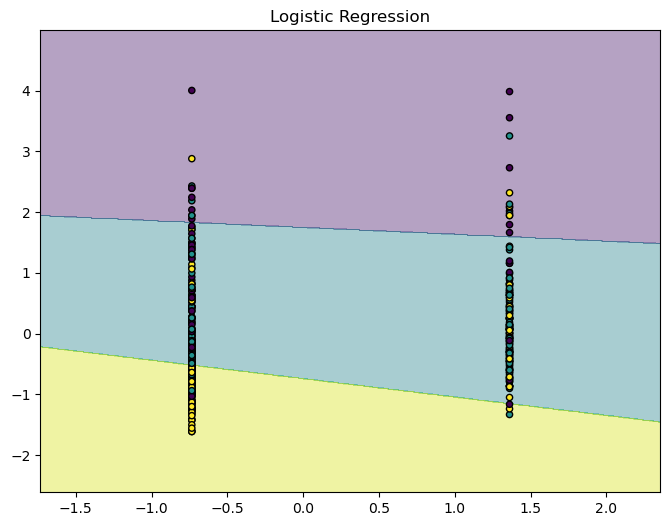

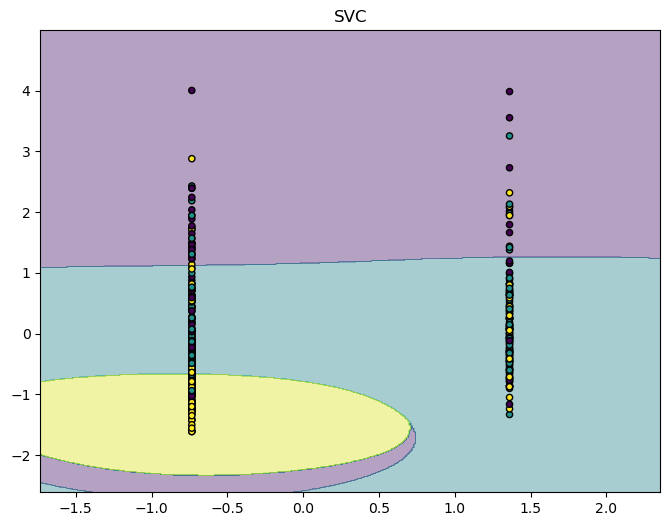

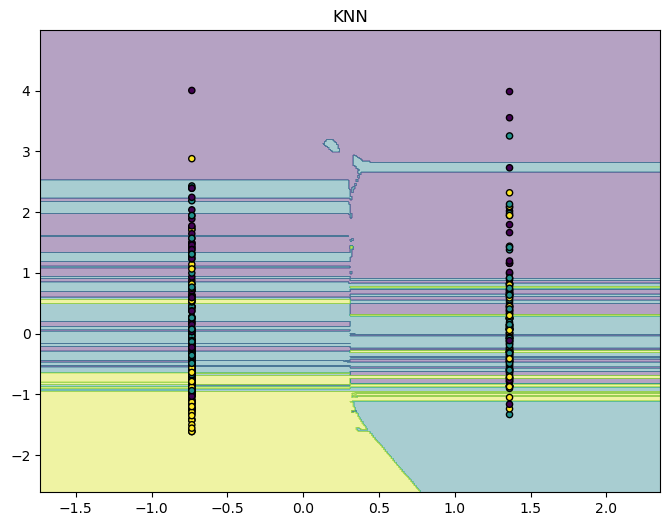

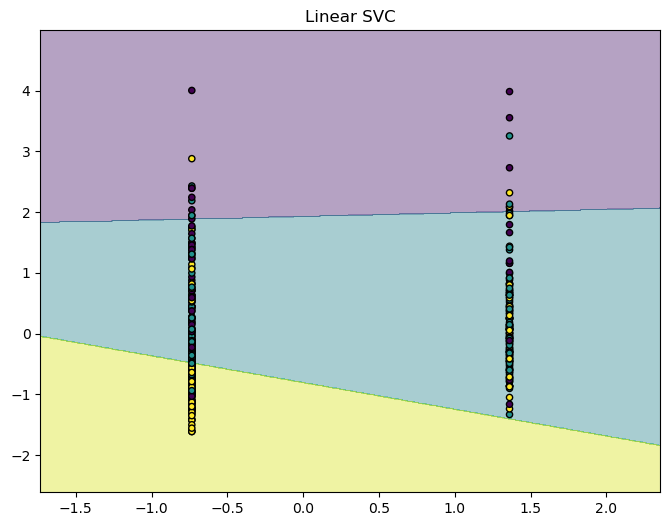

In [93]:
y_encoded = label_encoder.fit_transform(df['furnishingstatus'])

X_train_red, X_test_red, y_train_encoded, y_test_encoded = train_test_split(
    X_reduced_scaled, y_encoded, test_size=0.2, random_state=42
)

log_reg.fit(X_train_red, y_train_encoded)
svc.fit(X_train_red, y_train_encoded)
knn.fit(X_train_red, y_train_encoded)
linear_svc.fit(X_train_red, y_train_encoded)

def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    if not np.all(np.isfinite(Z)):
        print("Non-finite predictions encountered.")
        return

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(log_reg, X_train_red, y_train_encoded, "Logistic Regression")
plot_decision_boundary(svc, X_train_red, y_train_encoded, "SVC")
plot_decision_boundary(knn, X_train_red, y_train_encoded, "KNN")
plot_decision_boundary(linear_svc, X_train_red, y_train_encoded, "Linear SVC")